In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE

In [2]:
DF = pd.read_csv('train.csv', index_col=[0])
DF.shape

(56000, 21)

In [3]:
DF.info()

<class 'pandas.core.frame.DataFrame'>
Index: 56000 entries, 0 to 63998
Data columns (total 21 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   worker_id                56000 non-null  object 
 1   survey_month             56000 non-null  object 
 2   worker_age               51726 non-null  float64
 3   job_sector               52017 non-null  object 
 4   estimated_annual_income  52076 non-null  float64
 5   monthly_gig_income       47604 non-null  float64
 6   num_savings_accounts     56000 non-null  int64  
 7   num_credit_cards         56000 non-null  int64  
 8   avg_credit_interest      54007 non-null  float64
 9   num_active_loans         50926 non-null  float64
 10  avg_loan_delay_days      56000 non-null  int64  
 11  missed_payment_events    49731 non-null  float64
 12  recent_credit_checks     53813 non-null  float64
 13  current_total_liability  55443 non-null  float64
 14  credit_utilization_rate  56

In [4]:
DF.describe()

,worker_age,estimated_annual_income,monthly_gig_income,num_savings_accounts,num_credit_cards,avg_credit_interest,num_active_loans,avg_loan_delay_days,missed_payment_events,recent_credit_checks,current_total_liability,credit_utilization_rate,monthly_investments,end_of_month_balance
count,51726.000000,5.207600e+04,47604.000000,56000.000000,56000.000000,54007.000000,50926.000000,56000.000000,49731.000000,53813.000000,55443.000000,56000.000000,51080.000000,55302.000000
mean,33.239125,1.847764e+05,4144.940613,16.906054,22.505857,14.250014,3.518399,20.931179,13.400394,5.627544,1418.509080,32.257797,196.081579,397.835424
std,10.784547,1.495797e+06,3199.911242,116.311458,129.614382,8.486129,2.456607,14.787599,6.240864,3.793041,1158.188602,5.130267,201.156252,213.612536
min,14.000000,6.035990e+03,204.485417,-1.000000,1.000000,0.500000,0.000000,-6.000000,0.000000,0.000000,0.230000,20.000000,0.000000,0.007760
25%,24.000000,1.892614e+04,1572.005108,3.000000,4.000000,7.000000,2.000000,10.000000,9.000000,3.000000,555.880000,28.001990,72.140163,264.939289
50%,33.000000,3.671124e+04,3028.468333,6.000000,6.000000,13.000000,3.000000,18.000000,14.000000,5.000000,1163.470000,32.279565,128.954291,331.802908
75%,42.000000,7.271873e+04,5919.943333,7.000000,7.000000,20.000000,5.000000,28.000000,18.000000,8.000000,1922.820000,36.476202,237.305018,464.525826
max,115.000000,2.419779e+07,15202.263333,1798.000000,1499.000000,33.500000,9.000000,69.000000,28.000000,16.000000,4997.100000,50.000000,1961.218850,1592.580519


In [5]:
DF.isna().sum()

worker_id                     0
survey_month                  0
worker_age                 4274
job_sector                 3983
estimated_annual_income    3924
monthly_gig_income         8396
num_savings_accounts          0
num_credit_cards              0
avg_credit_interest        1993
num_active_loans           5074
avg_loan_delay_days           0
missed_payment_events      6269
recent_credit_checks       2187
current_total_liability     557
credit_utilization_rate       0
credit_age_months          5058
min_payment_flag              0
monthly_investments        4920
spending_behavior          4231
end_of_month_balance        698
financial_stress_level        0
dtype: int64

In [6]:
DF.duplicated().sum()

np.int64(0)

In [7]:
DF['financial_stress_level'].value_counts() / DF.shape[0] # распредение уровня стресса

financial_stress_level
Moderate    0.525929
Low         0.293482
High        0.180589
Name: count, dtype: float64

## EDA

### Categorical Features EDA

In [8]:
categorical_features = ['survey_month', 'job_sector', 'spending_behavior', 'min_payment_flag']

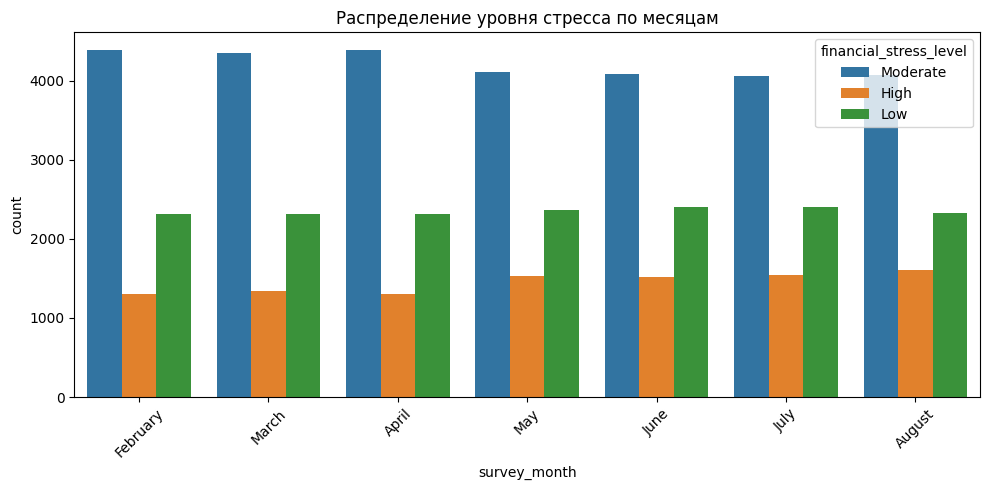

In [9]:
plt.figure(figsize=(10,5))
sns.countplot(data=DF, x='survey_month', hue='financial_stress_level')
plt.title("Распределение уровня стресса по месяцам")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

`Наблюдение`:
Летом снижается число людей с уровнем стресса moderate: часть переходит в категорию с низким стрессом, часть — в категорию с высоким.

`Вывод`:
У части людей с ранее стабильным уровнем стресса ближе к лету происходит либо его снижение, либо повышение. Можно было бы дополнительно проанализировать, у кого именно меняется стресс — по профессии, возрасту и другим признакам — но эту задачу можно оставить модели.

`Замечание по данным`:
Так как опрос проводился не во все месяцы, есть риск, что эта фича окажется малополезной: модель не увидит, как распределения меняются в другие периоды. Берём её «на карандаш» для возможного удаления.

<Figure size 640x480 with 0 Axes>

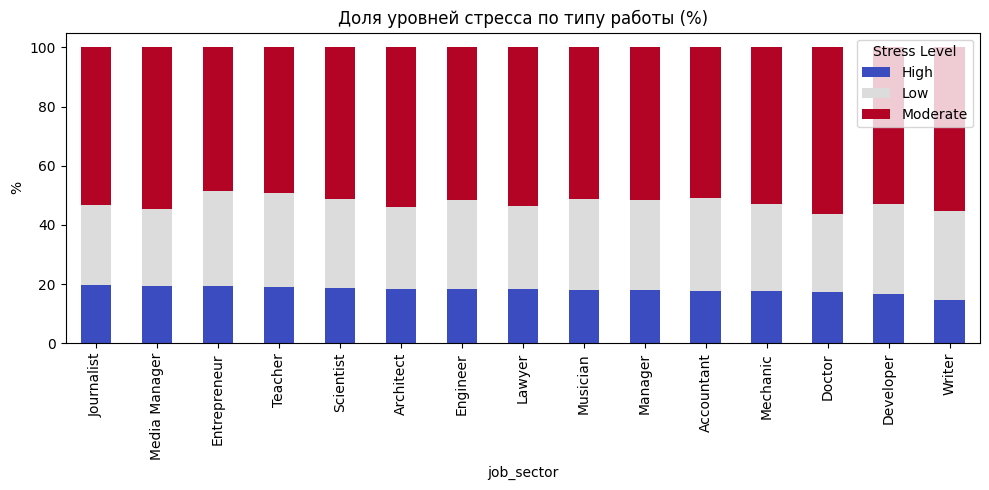

In [10]:
plt.figure()

job_sector_stress = pd.crosstab(DF['job_sector'], DF['financial_stress_level'], normalize='index') * 100
job_sector_stress = job_sector_stress.sort_values(['High'], ascending=False)
job_sector_stress.plot(kind='bar', stacked=True, figsize=(10,5), colormap="coolwarm")

plt.title("Доля уровней стресса по типу работы (%)")
plt.ylabel("%")
plt.legend(title="Stress Level")
plt.tight_layout()
plt.show()

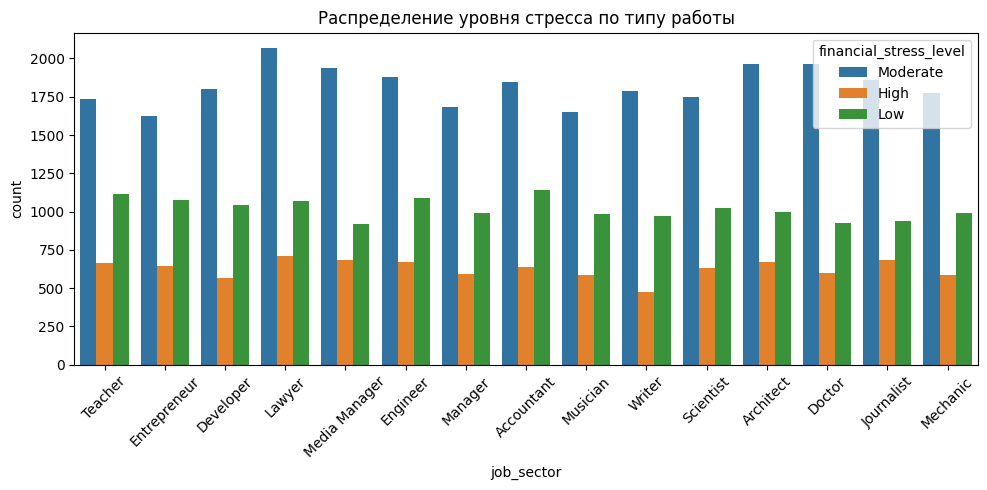

In [11]:
plt.figure(figsize=(10,5))
sns.countplot(data=DF, x='job_sector', hue='financial_stress_level')
plt.title("Распределение уровня стресса по типу работы")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

`Наблюдение`:
Каждая профессия демонстрирует уникальное распределение уровня финансового стресса по трём категориям. Визуально можно выделить профессии, где преобладают спокойные или, наоборот, более тревожные работники.

`Вывод`:
Признак потенциально ценен для модели, так как распределение категорий стресса существенно отличается между профессиями. Возможна дополнительная аналитика по каждой профессии — например, сравнение доходов, количества кредитов и других финансовых характеристик.

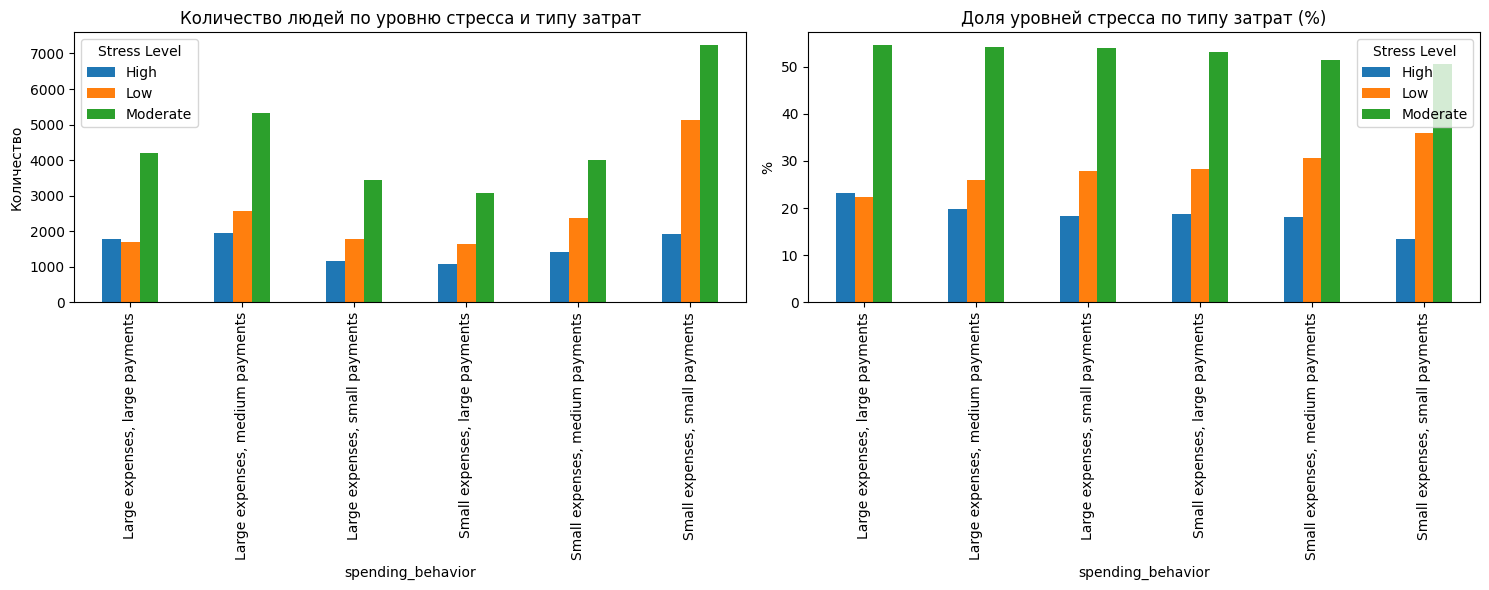

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

spending_behavior_stress_abs = pd.crosstab(DF['spending_behavior'], DF['financial_stress_level'])
spending_behavior_stress_abs.plot(kind='bar', ax=axs[0])

axs[0].set_title("Количество людей по уровню стресса и типу затрат")
axs[0].set_ylabel("Количество")
axs[0].legend(title="Stress Level")


spending_behavior_stress_pct = pd.crosstab(DF['spending_behavior'], DF['financial_stress_level'], normalize='index') * 100
spending_behavior_stress_pct.plot(kind='bar', ax=axs[1])

axs[1].set_title("Доля уровней стресса по типу затрат (%)")
axs[1].set_ylabel("%")
axs[1].legend(title="Stress Level")

plt.tight_layout()
plt.show()

`Наблюдение`:
Во всех категориях расходов преобладает уровень Moderate. high чаще встречается у людей с крупными расходами, а low - у тех, у кого расходы небольшие.

`Вывод`:
Категория расходов и платежи заметно коррелируют с уровнем стресса, что делает этот признак ценным для модели. Примечательно, что люди с низкими расходами чаще всего не испытывают финансового стресса. Это резко контрастирует с группой, которая тратит много — их численно меньше, но доля High у них почти в два раза выше.

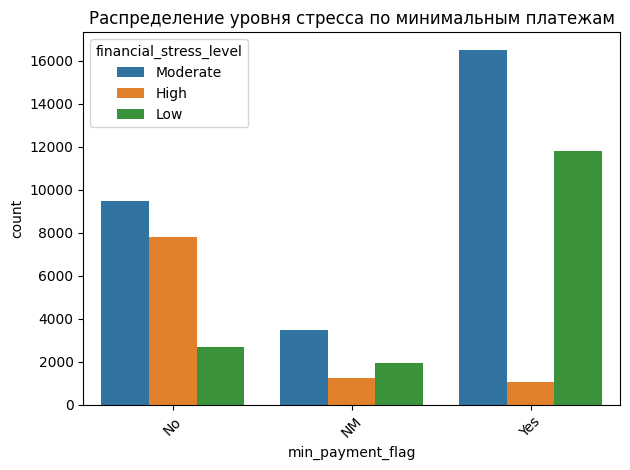

In [13]:
plt.figure()
sns.countplot(data=DF, x='min_payment_flag', hue='financial_stress_level')
plt.title("Распределение уровня стресса по минимальным платежам")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Numerical Features EDA

Я поделил графики по группам

#### Батч 1 - кредитная нагрузка

In [14]:
def age_to_months(age_str):
    if pd.isna(age_str):
        return np.nan
    years, months = age_str.split('y.')
    years = int(years.strip())
    months = int(months.replace('m.', '').strip())
    
    return years * 12 + months

DF['credit_age_months'] = DF['credit_age_months'].apply(age_to_months)

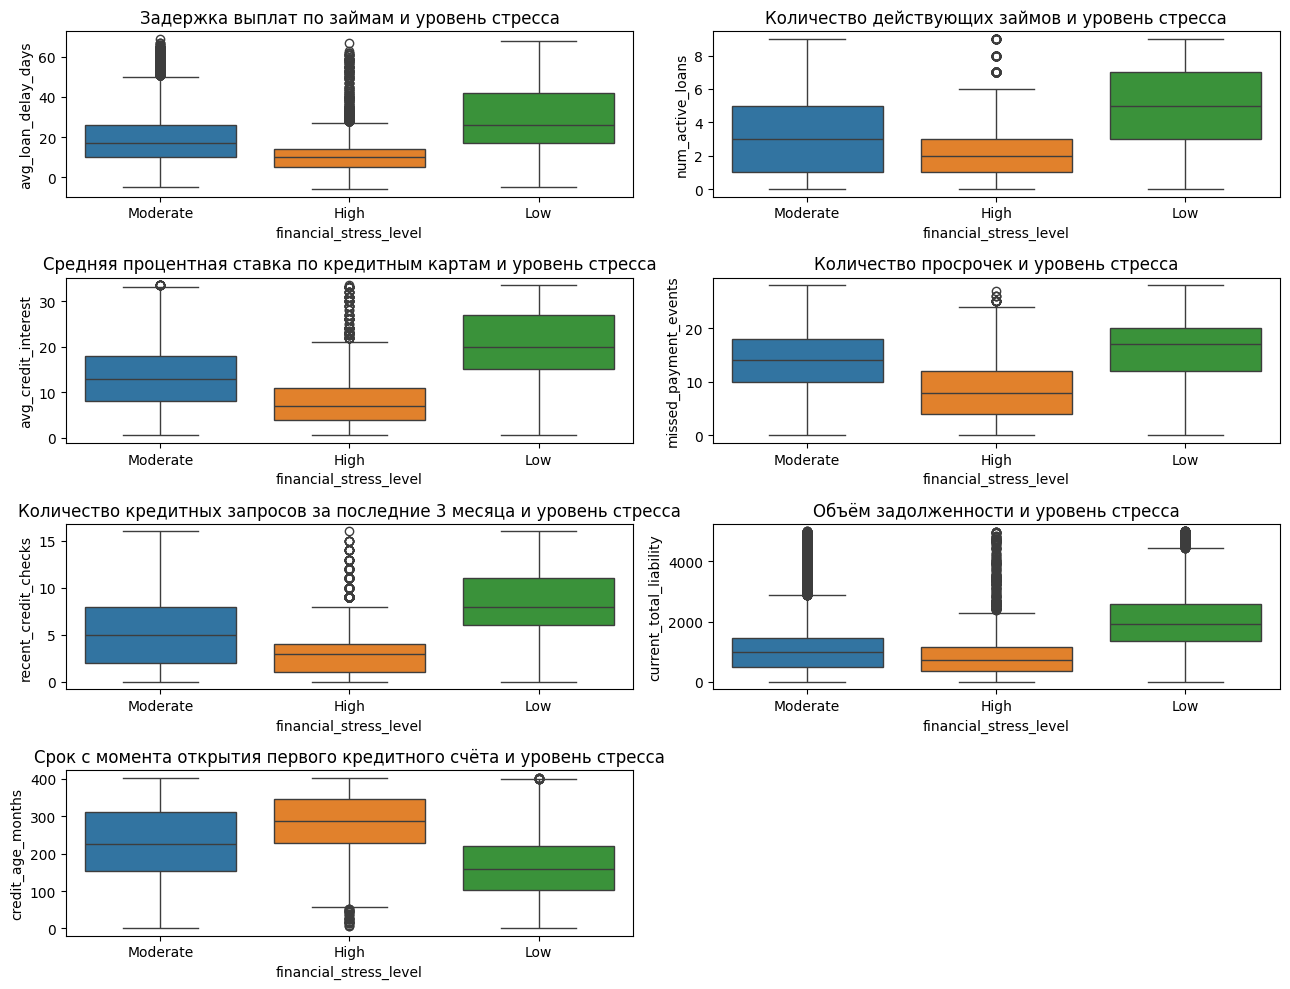

In [15]:
fig, axs = plt.subplots(4, 2, figsize=(13, 10))

sns.boxplot(data=DF, x='financial_stress_level', y='avg_loan_delay_days', ax=axs[0, 0], hue='financial_stress_level')
axs[0, 0].set_title('Задержка выплат по займам и уровень стресса')

sns.boxplot(data=DF, x='financial_stress_level', y='num_active_loans', ax=axs[0, 1], hue='financial_stress_level')
axs[0, 1].set_title('Количество действующих займов и уровень стресса')

sns.boxplot(data=DF, x='financial_stress_level', y='avg_credit_interest', ax=axs[1, 0], hue='financial_stress_level')
axs[1, 0].set_title('Средняя процентная ставка по кредитным картам и уровень стресса')

sns.boxplot(data=DF, x='financial_stress_level', y='missed_payment_events', ax=axs[1, 1], hue='financial_stress_level')
axs[1, 1].set_title('Количество просрочек и уровень стресса')

sns.boxplot(data=DF, x='financial_stress_level', y='recent_credit_checks', ax=axs[2, 0], hue='financial_stress_level')
axs[2, 0].set_title('Количество кредитных запросов за последние 3 месяца и уровень стресса')

sns.boxplot(data=DF, x='financial_stress_level', y='current_total_liability', ax=axs[2, 1], hue='financial_stress_level')
axs[2, 1].set_title('Объём задолженности и уровень стресса')

sns.boxplot(data=DF, x='financial_stress_level', y='credit_age_months', ax=axs[3, 0], hue='financial_stress_level')
axs[3, 0].set_title('Cрок с момента открытия первого кредитного счёта и уровень стресса')

axs[3, 1].axis("off")

plt.tight_layout()
plt.show()

`Наблюдение`:
Люди с большим количеством кредитов, высокими процентными ставками, значительной задолженностью и частыми пропусками платежей зачастую относятся к категории Low по уровню стресса. Наоборот, те, у кого уровень стресса High, обычно имеют меньше кредитов и долгов. Moderate располагаются между ними.

`Вывод`:
Эти признаки важно оставить в модели. Интересно, что менее финансово дисциплинированные люди демонстрируют меньший стресс. В сочетании с графиком по возрасту можно предположить: молодые люди тратят больше и меньше переживают, тогда как старшие более экономны, но испытывают больший стресс.

#### Батч 2 - доходы, баланс и инвестиции

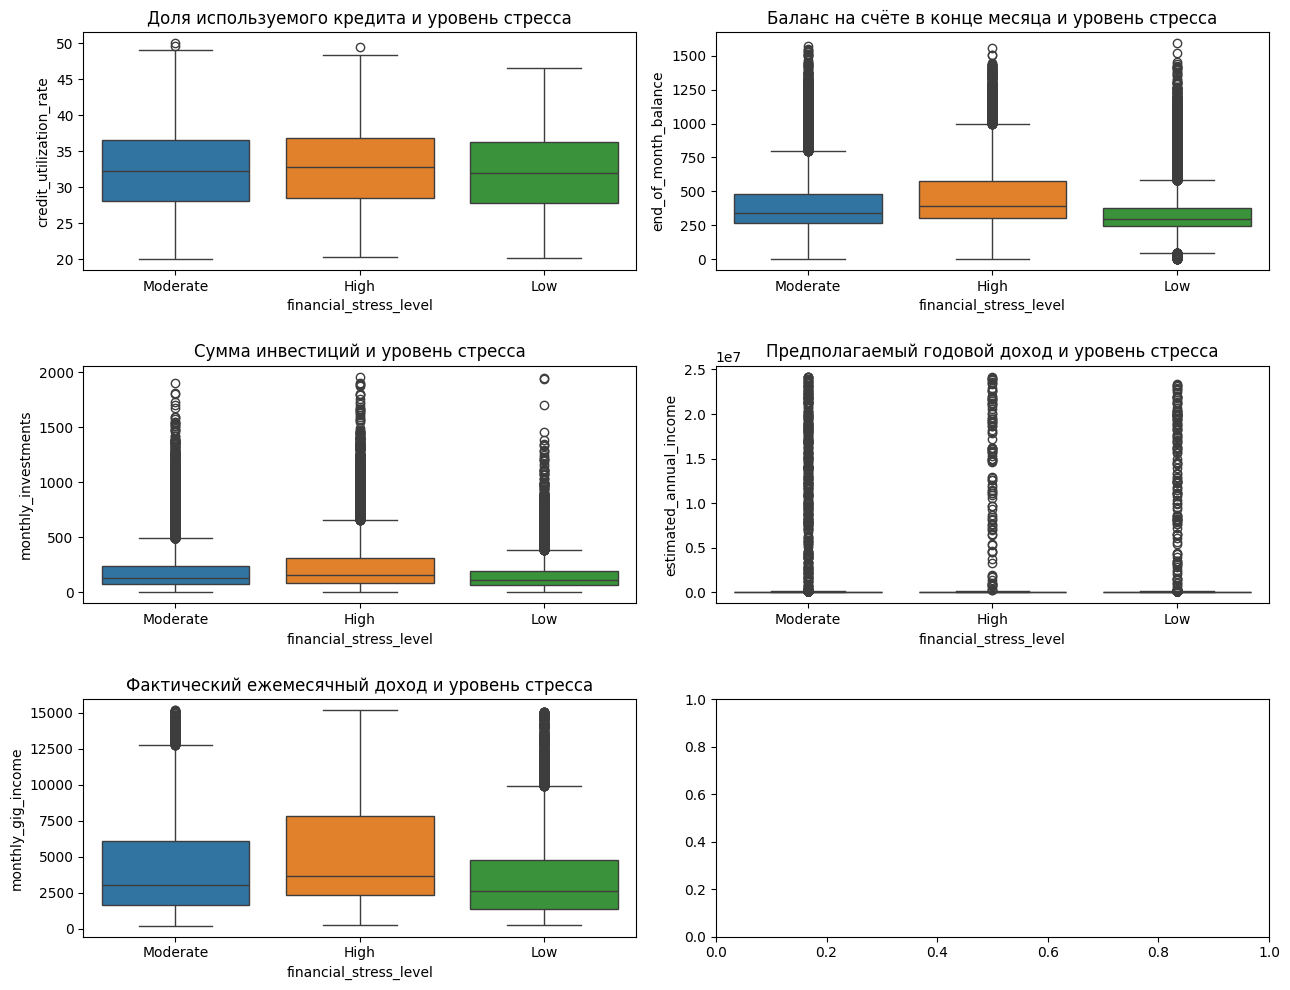

In [16]:
fig, axs = plt.subplots(3, 2, figsize=(13, 10))

sns.boxplot(data=DF, x='financial_stress_level', y='credit_utilization_rate', ax=axs[0, 0], hue='financial_stress_level')
axs[0, 0].set_title('Доля используемого кредита и уровень стресса')

sns.boxplot(data=DF, x='financial_stress_level', y='end_of_month_balance', ax=axs[0, 1], hue='financial_stress_level')
axs[0, 1].set_title('Баланс на счёте в конце месяца и уровень стресса')

sns.boxplot(data=DF, x='financial_stress_level', y='monthly_investments', ax=axs[1, 0], hue='financial_stress_level')
axs[1, 0].set_title('Сумма инвестиций и уровень стресса')

sns.boxplot(data=DF, x='financial_stress_level', y='estimated_annual_income', ax=axs[1, 1], hue='financial_stress_level')
axs[1, 1].set_title('Предполагаемый годовой доход и уровень стресса')

sns.boxplot(data=DF, x='financial_stress_level', y='monthly_gig_income', ax=axs[2, 0], hue='financial_stress_level')
axs[2, 0].set_title('Фактический ежемесячный доход и уровень стресса')

plt.tight_layout()
plt.show()

`Наблюдение`:
Выявлены значительные выбросы в данных по предполагаемому годовому доходу. Возникает вопрос о целесообразности использования этого признака в дальнейшем анализе.

`Вывод`:
Представленные графики подтверждают ранее сделанное предположение: при меньшем объёме свободных средств в конце месяца и меньших инвестициях люди испытывают меньше стресса.

#### Батч 3 - коливество счетов

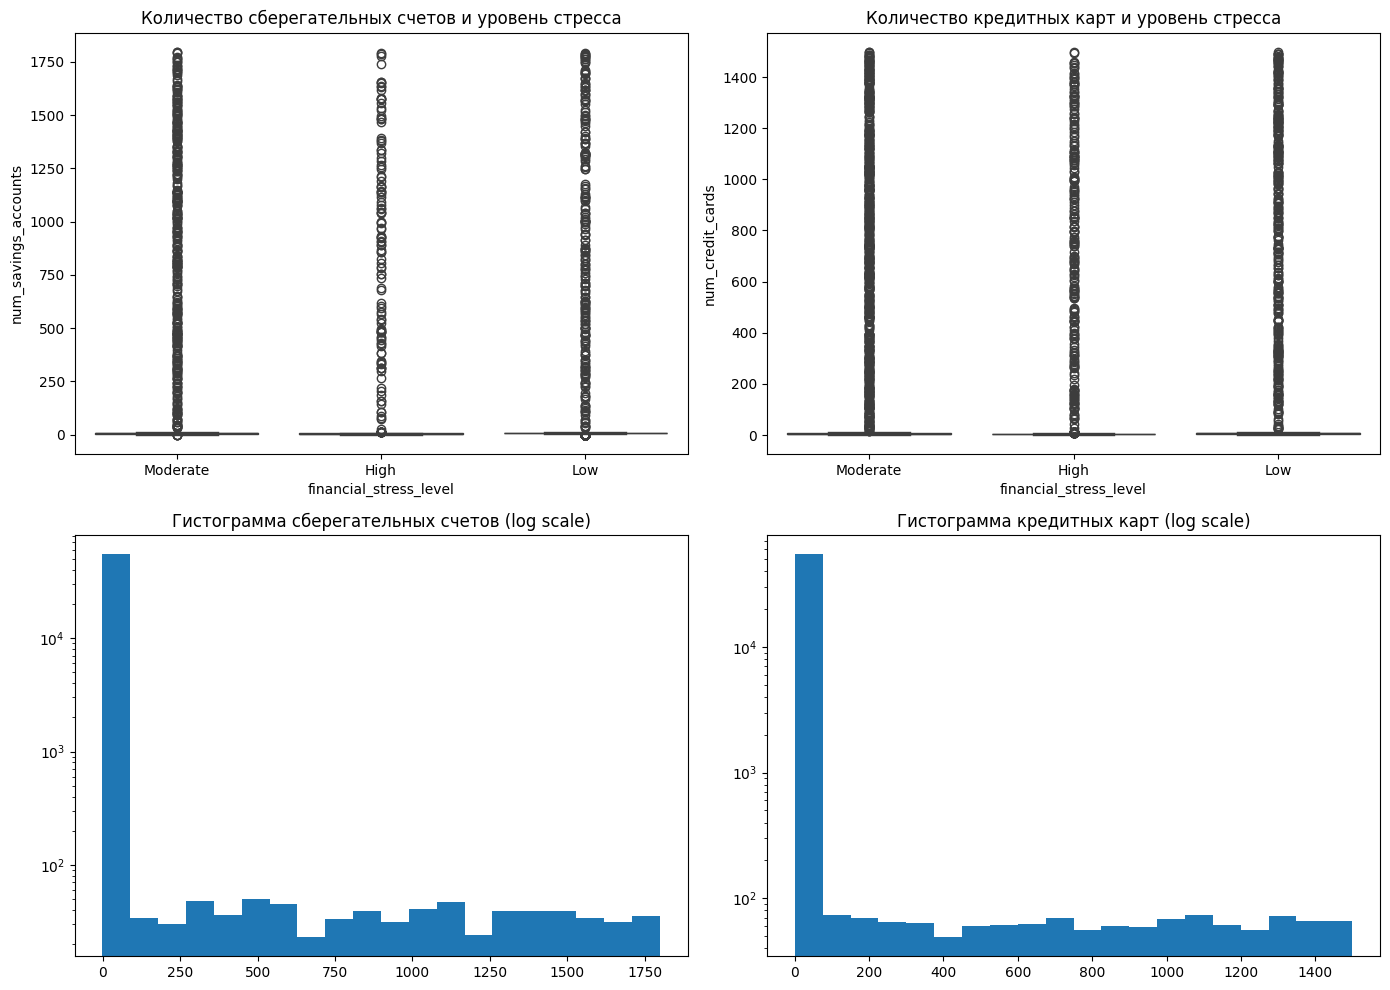

In [17]:
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

sns.boxplot(data=DF, x='financial_stress_level', y='num_savings_accounts', ax=axs[0, 0], hue='financial_stress_level')
axs[0, 0].set_title('Количество сберегательных счетов и уровень стресса')

sns.boxplot(data=DF, x='financial_stress_level', y='num_credit_cards', ax=axs[0, 1], hue='financial_stress_level')
axs[0, 1].set_title('Количество кредитных карт и уровень стресса')

axs[1, 0].hist(DF['num_savings_accounts'], bins=20)
axs[1, 0].set_yscale('log')
axs[1, 0].set_title('Гистограмма сберегательных счетов (log scale)')

axs[1, 1].hist(DF['num_credit_cards'], bins=20)
axs[1, 1].set_yscale('log')
axs[1, 1].set_title('Гистограмма кредитных карт (log scale)')

plt.tight_layout()
plt.show()

`Наблюдение`:
Выявлены значительные выбросы в данных по количеству сберегательных счетов и кредитных карт. Это ставит под сомнение корректность данных и вызывает вопрос о целесообразности использования этих признаков в дальнейшем анализе.

`Вывод`:
С высокой вероятностью данные содержат ошибки, так как наличие более 1000 счетов или карт у одного человека представляется крайне маловероятным.

#### Батч 4 - возраст

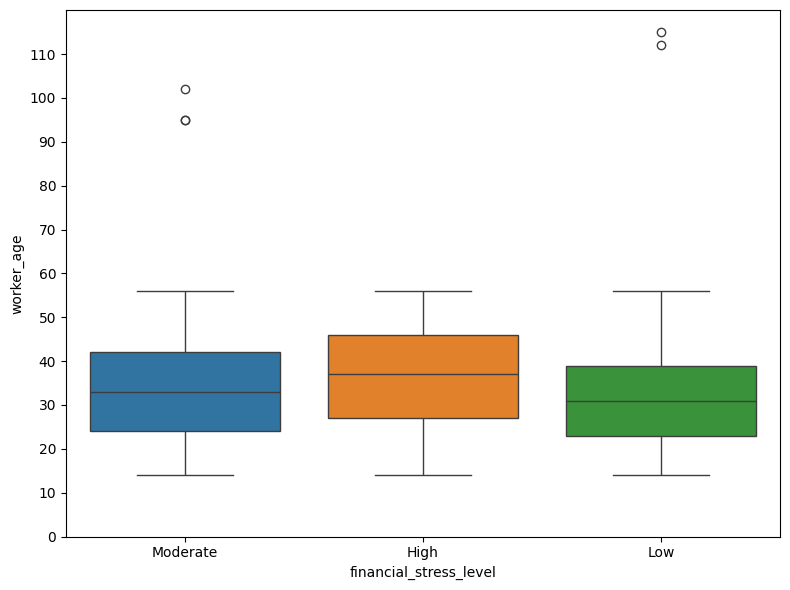

In [18]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=DF, x='financial_stress_level', y='worker_age', hue='financial_stress_level')
plt.yticks(range(0, 120, 10))
plt.tight_layout()
plt.show()

`Наблюдение`:
Молодые сотрудники в среднем испытывают меньший уровень стресса. При этом в данных присутствуют выбросы, например сотрудники с возрастом 120 лет, которые явно нелогичны.

`Вывод`:
Фичу оставляем, так как она является информативной для модели. Выбросы следует удалить, чтобы улучшить качество данных и корректность анализа.

### Data Cleaning

In [19]:
feature_map_dict = {}
means_dict = {}

In [20]:
DF.drop('worker_id', axis=1, inplace=True)

In [21]:
DF = DF[~(DF['worker_age'] > 60)] # удалить выбросы по возврасту

feature_map_dict['worker_age'] = DF.groupby('job_sector')['worker_age'].mean() # найти средний возраст для каждой профессии

DF['worker_age'] = DF['worker_age'].fillna(DF['job_sector'].map(feature_map_dict['worker_age'])) # заполнить пропуски средними значениями

In [22]:
DF.dropna(subset='job_sector', inplace=True) # удалить пропуски фиче job_sector 
DF['worker_age'].astype(int)

1        28
2        28
3        28
4        28
5        28
         ..
63994    45
63995    45
63996    33
63997    45
63998    45
Name: worker_age, Length: 52012, dtype: int64

In [23]:
def convert_outliers_to_mean(dataframe, feature):
    print(f"Средняя до препроцесса: {DF[feature].mean().item()}")

    feature_mean = DF[feature].mean()

    Q1 = DF[feature].quantile(0.25)
    Q3 = DF[feature].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    condition = (DF[feature] < lower_bound) | (DF[feature] > upper_bound)
    num_outliers = DF[condition].shape[0]
    DF.loc[condition, feature] = feature_mean
    feature_mean = DF[feature].mean()
    
    print(f"Количество выбросов: {num_outliers}")
    print(f"Средняя после препроцесса: {DF[feature].mean().item()}")

    sns.boxplot(data=DF, x='financial_stress_level', y=feature, hue='financial_stress_level')
    plt.show()

    return feature_mean

Средняя до препроцесса: 183787.73511776992
Количество выбросов: 1323
Средняя после препроцесса: 51636.30700748206


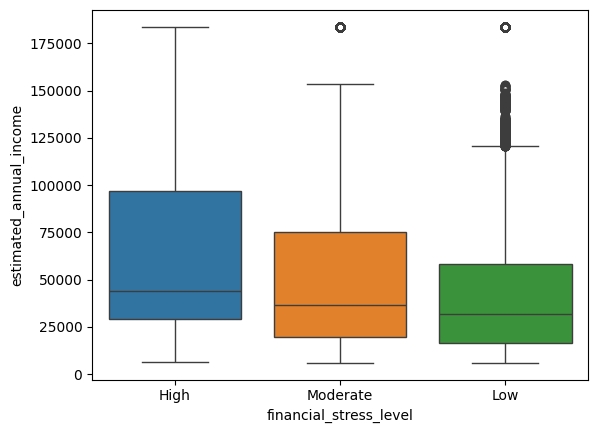

Средняя до препроцесса: 16.88258478812582
Количество выбросов: 673
Средняя после препроцесса: 5.501729976974712


C:\Users\karib\AppData\Local\Temp\ipykernel_30684\547823196.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  DF[col].fillna(means_dict[col], inplace=True)
C:\Users\karib\AppData\Local\Temp\ipykernel_30684\2848762235.py:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '16.88258478812582' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  DF.loc[condition, feature] = feature_mean


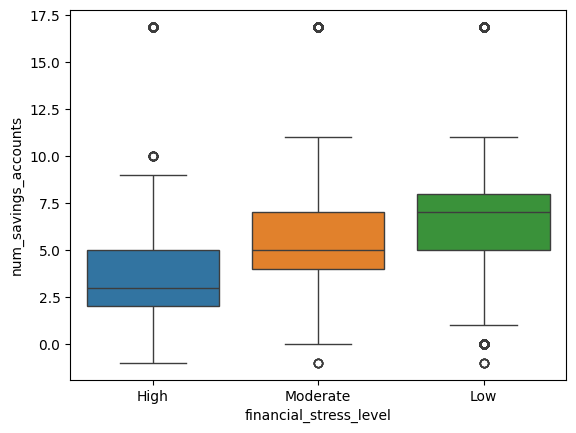

C:\Users\karib\AppData\Local\Temp\ipykernel_30684\547823196.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  DF[col].fillna(means_dict[col], inplace=True)
C:\Users\karib\AppData\Local\Temp\ipykernel_30684\2848762235.py:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '22.48961778051219' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  DF.loc[condition, feature] = feature_mean


Средняя до препроцесса: 22.48961778051219
Количество выбросов: 1171
Средняя после препроцесса: 5.911892302179876


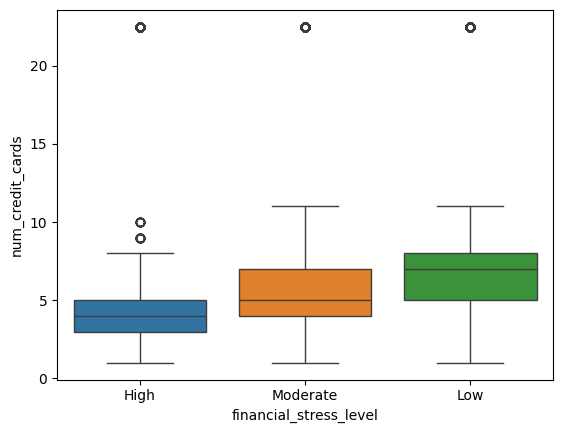

C:\Users\karib\AppData\Local\Temp\ipykernel_30684\547823196.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  DF[col].fillna(means_dict[col], inplace=True)


Средняя до препроцесса: 4146.053906379489
Количество выбросов: 887
Средняя после препроцесса: 3952.6789448892087


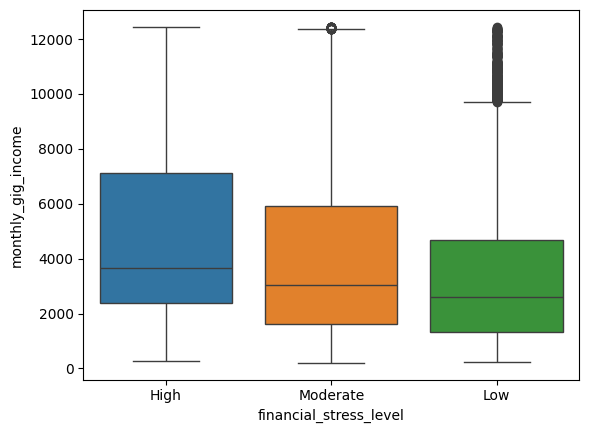

C:\Users\karib\AppData\Local\Temp\ipykernel_30684\547823196.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  DF[col].fillna(means_dict[col], inplace=True)


In [24]:
features_to_convert_outliers_to_mean = ['estimated_annual_income', 'num_savings_accounts', 'num_credit_cards', 'monthly_gig_income']
for col in features_to_convert_outliers_to_mean:
    means_dict[col] = convert_outliers_to_mean(DF, col)
    DF[col].fillna(means_dict[col], inplace=True)

In [25]:
means_dict['worker_age'] = DF['worker_age'].mean()

In [26]:
numeric_cols  = ['avg_credit_interest', 'num_active_loans', 'missed_payment_events',
                 'recent_credit_checks', 'current_total_liability', 'credit_age_months', 'monthly_investments',
                 'end_of_month_balance'
                ]

for col in numeric_cols:        
    feature_map_dict[col] = DF.groupby('worker_age')[col].mean()
    DF[col] = DF[col].fillna(DF['worker_age'].map(feature_map_dict[col]))

In [27]:
feature_map_dict['spending_behavior'] = (DF.groupby('worker_age')['spending_behavior'].apply(lambda x: x.value_counts().idxmax()))

DF['spending_behavior'] = DF['spending_behavior'].fillna(DF['worker_age'].map(feature_map_dict['spending_behavior']))

In [28]:
DF.isna().sum()

survey_month               0
worker_age                 0
job_sector                 0
estimated_annual_income    0
monthly_gig_income         0
num_savings_accounts       0
num_credit_cards           0
avg_credit_interest        0
num_active_loans           0
avg_loan_delay_days        0
missed_payment_events      0
recent_credit_checks       0
current_total_liability    0
credit_utilization_rate    0
credit_age_months          0
min_payment_flag           0
monthly_investments        0
spending_behavior          0
end_of_month_balance       0
financial_stress_level     0
dtype: int64

### One-Hot Encoding

In [29]:
from sklearn.preprocessing import OneHotEncoder


categorical_features = ['job_sector', 'spending_behavior', 'min_payment_flag']
month_feature = 'survey_month'

all_months = ['March', 'April', 'May', 'June', 'July', 'August', 
              'February', 'September', 'October', 'November', 'December', 'January']

ohe_cat = OneHotEncoder(handle_unknown='ignore', sparse_output=False, drop='first')
encoded_cat = ohe_cat.fit_transform(DF[categorical_features])
encoded_cat_df = pd.DataFrame(encoded_cat, columns=ohe_cat.get_feature_names_out(categorical_features), index=DF.index)

ohe_month = OneHotEncoder(categories=[all_months], handle_unknown='ignore', sparse_output=False, drop='first')
encoded_month = ohe_month.fit_transform(DF[[month_feature]])
encoded_month_df = pd.DataFrame(encoded_month, columns=ohe_month.get_feature_names_out([month_feature]), index=DF.index)

DF = pd.concat([DF.drop(columns=categorical_features + [month_feature]), encoded_cat_df, encoded_month_df], axis=1)

------------------------------------

In [30]:
target_map = {val: i - 1 for i, val in enumerate(DF['financial_stress_level'].unique(), start=1)} # target encoding
DF['financial_stress_level'] = DF['financial_stress_level'].map(target_map)

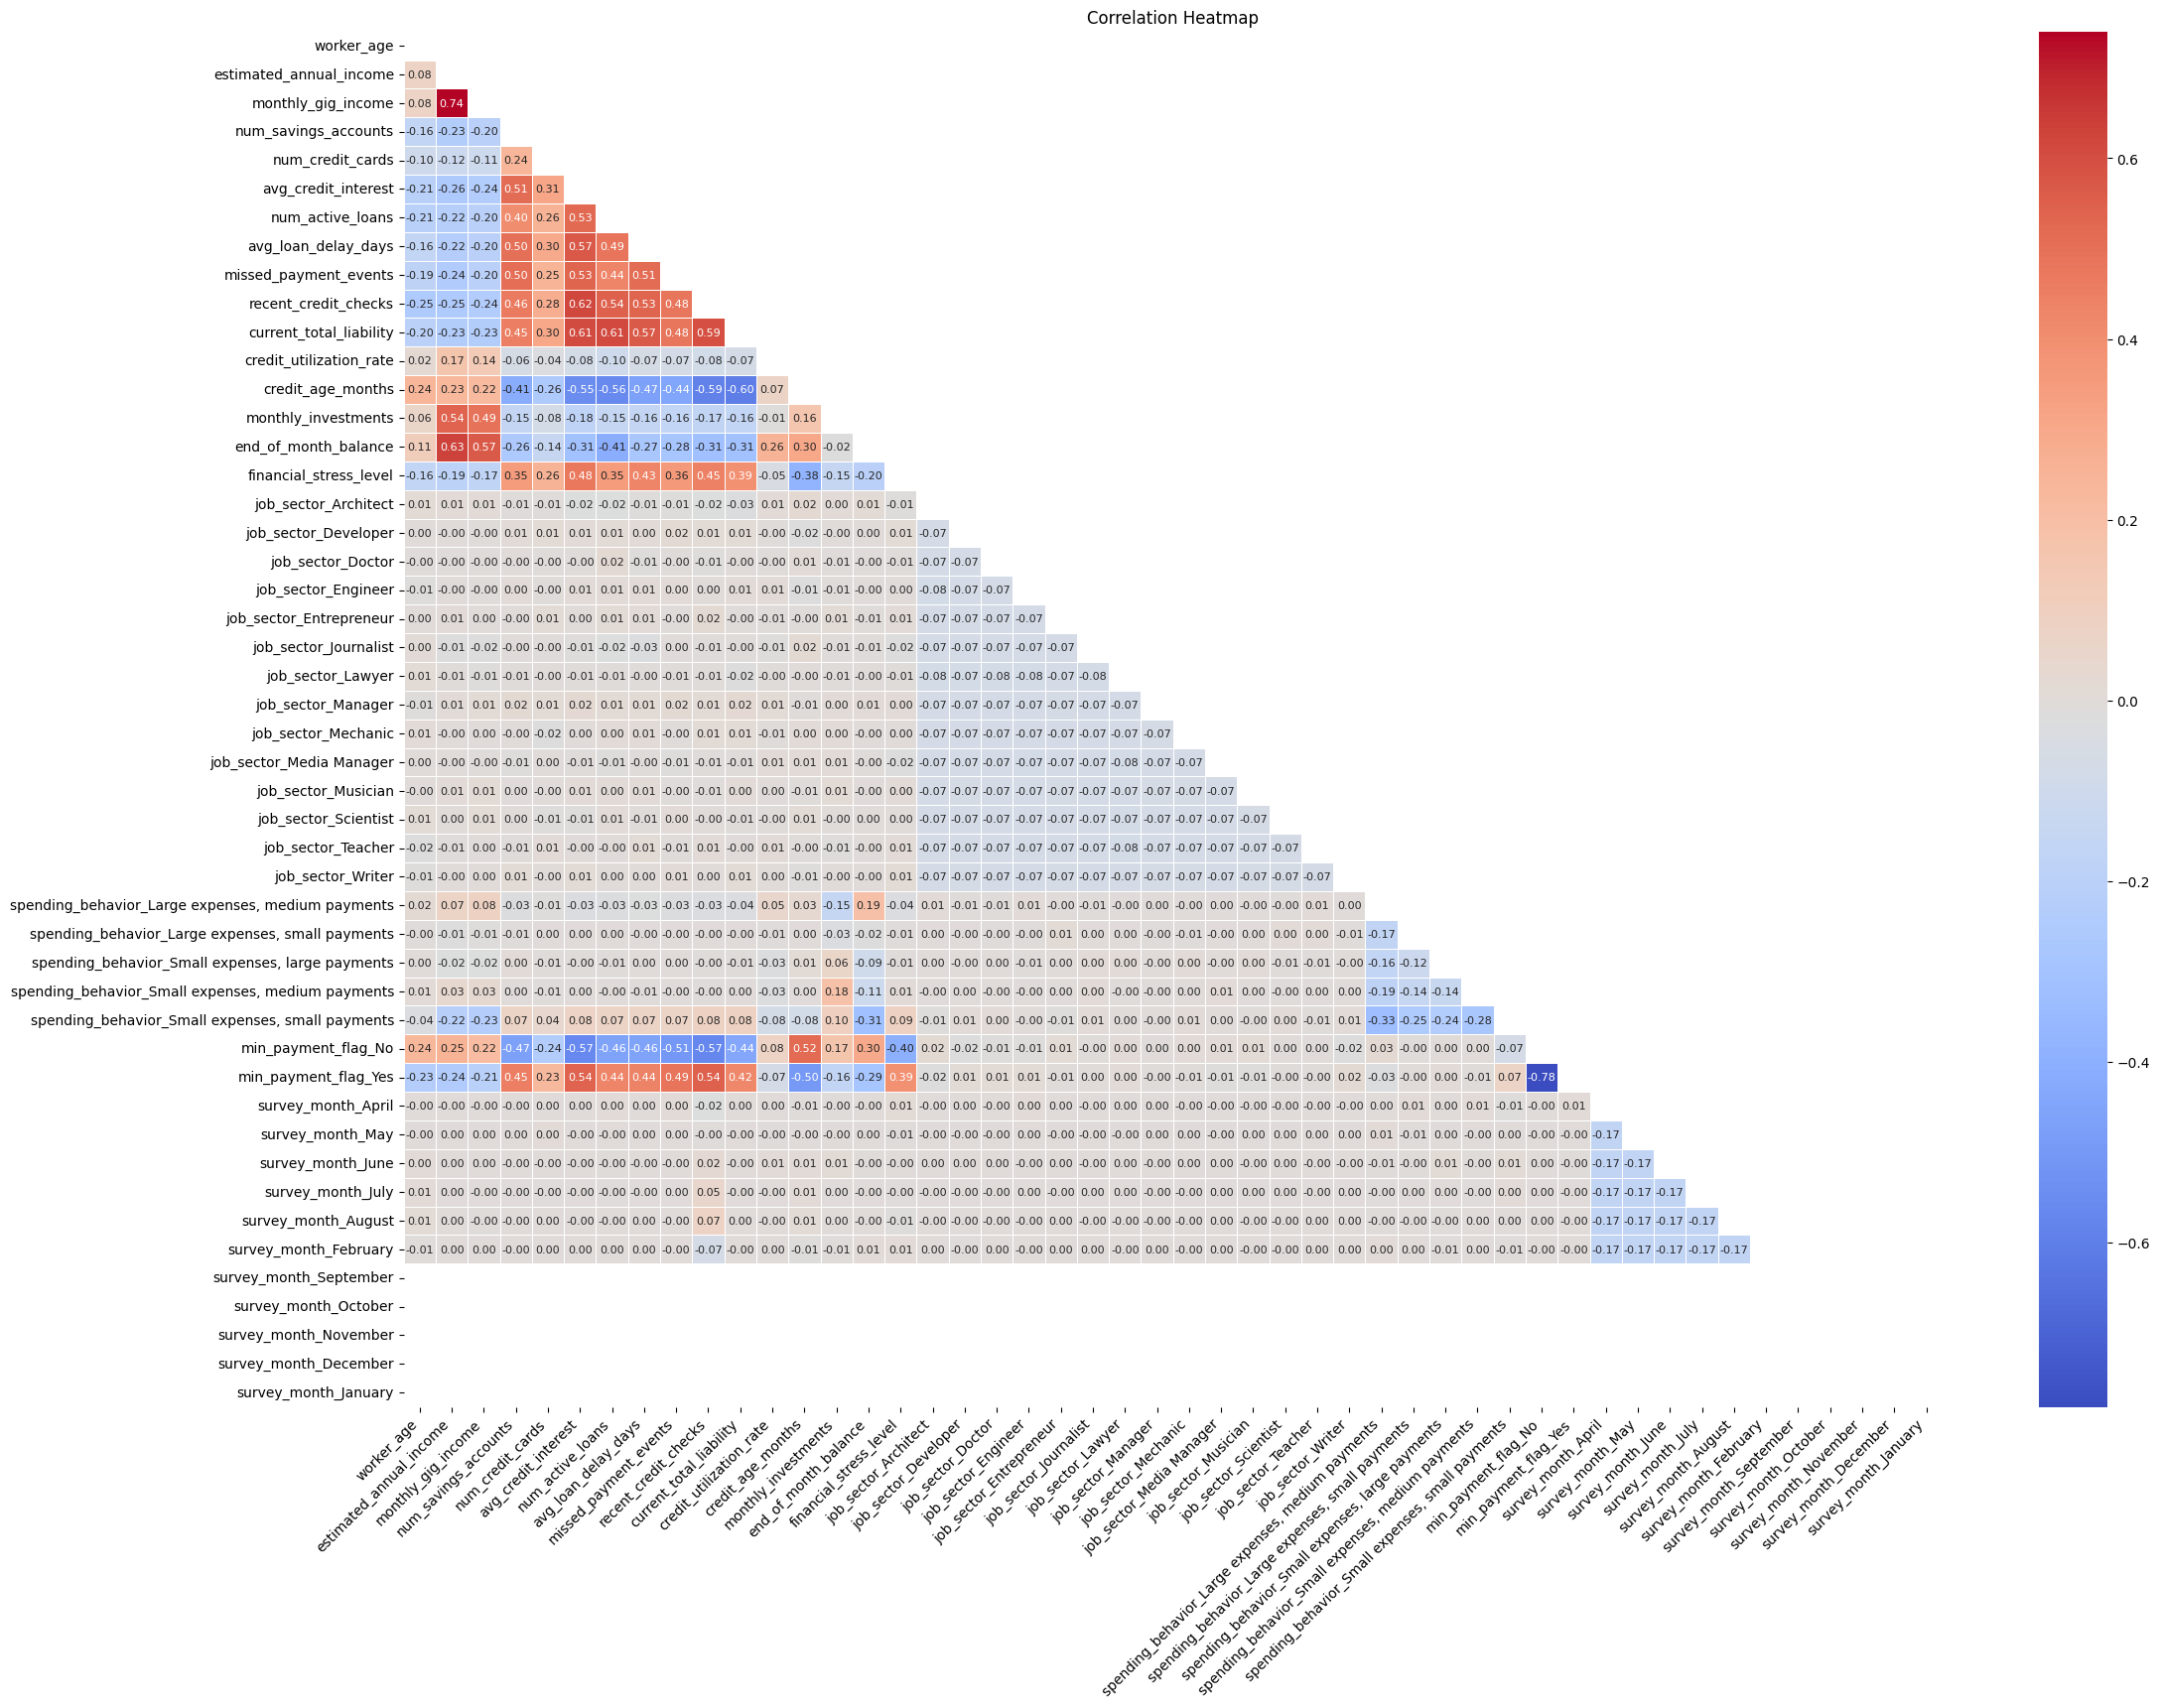

In [31]:
numeric_df = DF.select_dtypes(include=[np.number])
corr_matrix = numeric_df.corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

plt.figure(figsize=(25, 18))
sns.heatmap(
    corr_matrix,
    mask=mask,
    annot=True,
    fmt=".2f",
    cmap='coolwarm',
    linewidths=0.5,
    annot_kws={"size": 8}
)
plt.title("Correlation Heatmap")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.show()

### Training

In [32]:
from sklearn.metrics import accuracy_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
from catboost import CatBoostClassifier
import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler

import pandas as pd

from sklearn.ensemble import StackingRegressor

In [33]:
X = DF.drop('financial_stress_level', axis=1)
y = DF['financial_stress_level']

columns_order = X.columns

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.02, random_state=42, stratify=True)

In [34]:
results = {}

In [35]:
# ====== 2. Logistic Regression ======
lr = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=500)

lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_val)

results['Logistic Regression'] = [accuracy_score(y_val, y_pred_lr), f1_score(y_val, y_pred_lr, average='macro')]

C:\Users\karib\anaconda3\envs\dl\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


In [36]:
# ====== 3. Random Forest ======
rf = RandomForestClassifier(n_estimators=100, random_state=42)

rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_val)

results['Random Forest'] = [accuracy_score(y_val, y_pred_rf), f1_score(y_val, y_pred_rf, average='macro')]

In [37]:
# ====== 4. XGBoost ======
xgb_clf = xgb.XGBClassifier(
    random_state=42,
    n_estimators=500,
    max_depth=10,
    learning_rate=0.1,
    subsample=0.9,
    colsample_bytree=0.8,
    reg_alpha=0.1,
    reg_lambda=1,
    use_label_encoder=False,
    eval_metric='mlogloss',
    n_jobs=-1,
    class_weight='balanced'
)

xgb_clf.fit(X_train, y_train)
y_pred_xgb = xgb_clf.predict(X_val)

results['XGBoost'] = [accuracy_score(y_val, y_pred_xgb), f1_score(y_val, y_pred_xgb, average='macro')]

C:\Users\karib\anaconda3\envs\dl\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:14:53] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "class_weight", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [38]:
# ====== 5. CatBoost ======
cat_clf = CatBoostClassifier(
    iterations=1000,
    depth=8,
    learning_rate=0.05,
    l2_leaf_reg=3,
    random_state=42,
    verbose=0,
    early_stopping_rounds=50
)

cat_clf.fit(
    X_train, y_train,
    eval_set=(X_val, y_val),
    use_best_model=True
)
y_pred_cat = cat_clf.predict(X_val)

results['CatBoost'] = [accuracy_score(y_val, y_pred_cat), f1_score(y_val, y_pred_cat, average='macro')]

In [39]:
# ====== 6. kNN ======
knn = KNeighborsClassifier(n_neighbors=100)

knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_val)

results['kNN'] = [accuracy_score(y_val, y_pred_knn), f1_score(y_val, y_pred_knn, average='macro')]

In [40]:
results

{'Logistic Regression': [0.611911623439001, np.float64(0.5656384006376118)],
 'Random Forest': [0.7877041306436119, np.float64(0.7682621196926757)],
 'XGBoost': [0.8069164265129684, np.float64(0.7921903260173799)],
 'CatBoost': [0.7694524495677233, np.float64(0.7458171754333631)],
 'kNN': [0.6311239193083573, np.float64(0.5499801035608769)]}

In [41]:
df_pred = pd.DataFrame({
    "KNN": y_pred_knn,
    "XGBoost": y_pred_xgb,
    "RandomForest": y_pred_rf,
    "LogReg": y_pred_lr,
    "CatBoost": y_pred_cat.squeeze(1),
    "Target": y_val
})

In [42]:
pred_columns = ["XGBoost", "RandomForest", "CatBoost"]
df_pred["VotingPred"] = df_pred[pred_columns].mode(axis=1)[0]

In [43]:
(df_pred['VotingPred'] == df_pred['Target']).sum() / df_pred.shape[0]

np.float64(0.8011527377521613)

### Testing

In [90]:
test_df = pd.read_csv('test.csv', index_col=[0])
worker_id = test_df['worker_id']
test_df.drop('worker_id', axis=1, inplace=True)

In [74]:
test_df.isna().sum()

worker_age                                           0
estimated_annual_income                              0
monthly_gig_income                                   0
num_savings_accounts                                 0
num_credit_cards                                     0
avg_credit_interest                                  0
num_active_loans                                     0
avg_loan_delay_days                                  0
missed_payment_events                                0
recent_credit_checks                                 0
current_total_liability                              0
credit_utilization_rate                              0
credit_age_months                                    0
monthly_investments                                  0
end_of_month_balance                                 0
job_sector_Architect                                 0
job_sector_Developer                                 0
job_sector_Doctor                                    0
job_sector

In [46]:
test_df['credit_age_months'] = test_df['credit_age_months'].apply(age_to_months)

In [47]:
test_df['worker_age'] = test_df['worker_age'].fillna(test_df['job_sector'].map(feature_map_dict['worker_age'])) # заполнить пропуски средними значениями
test_df['worker_age'] = test_df['worker_age'].fillna(means_dict['worker_age']) # заполнить пропуски средними значениями
test_df['worker_age'] = test_df['worker_age'].astype(int)

In [48]:
for col in features_to_convert_outliers_to_mean:
    test_df[col] = test_df[col].fillna(means_dict[col])

for col in numeric_cols:        
    test_df[col] = test_df[col].fillna(test_df['worker_age'].map(feature_map_dict[col]))

test_df['spending_behavior'] = test_df['spending_behavior'].fillna(test_df['worker_age'].map(feature_map_dict['spending_behavior']))

In [49]:
encoded_cat = ohe_cat.transform(test_df[categorical_features])
encoded_cat_df = pd.DataFrame(encoded_cat, columns=ohe_cat.get_feature_names_out(categorical_features), index=test_df.index)

encoded_month = ohe_month.transform(test_df[[month_feature]])
encoded_month_df = pd.DataFrame(encoded_month, columns=ohe_month.get_feature_names_out([month_feature]), index=test_df.index)

test_df = pd.concat([test_df.drop(columns=categorical_features + [month_feature]), encoded_cat_df, encoded_month_df], axis=1)

C:\Users\karib\anaconda3\envs\dl\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [73]:
test_df.isna().sum()

worker_age                                           0
estimated_annual_income                              0
monthly_gig_income                                   0
num_savings_accounts                                 0
num_credit_cards                                     0
avg_credit_interest                                  0
num_active_loans                                     0
avg_loan_delay_days                                  0
missed_payment_events                                0
recent_credit_checks                                 0
current_total_liability                              0
credit_utilization_rate                              0
credit_age_months                                    0
monthly_investments                                  0
end_of_month_balance                                 0
job_sector_Architect                                 0
job_sector_Developer                                 0
job_sector_Doctor                                    0
job_sector

In [51]:
test_df = test_df[columns_order]
X_test_scaled = scaler.transform(test_df)

In [98]:
y_test_pred = xgb_clf.predict(X_test_scaled)

C:\Users\karib\anaconda3\envs\dl\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


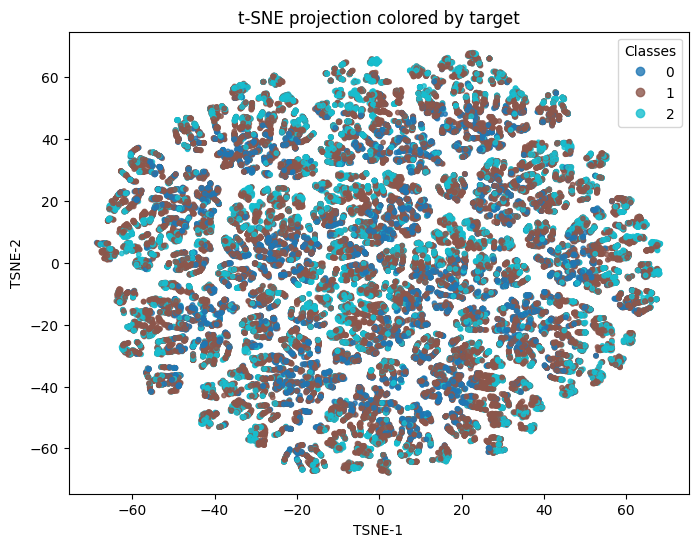

In [69]:
tsne = TSNE(
    n_components=2,
    perplexity=30,
    learning_rate=200,
    n_iter=1000,
    random_state=42
)

X_tsne = tsne.fit_transform(X_scaled)

plt.figure(figsize=(8,6))

scatter = plt.scatter(
    X_tsne[:,0],
    X_tsne[:,1],
    c=y, 
    cmap='tab10',
    s=10,
    alpha=0.8
)

plt.title('t-SNE projection colored by target')
plt.xlabel('TSNE-1')
plt.ylabel('TSNE-2')
plt.legend(*scatter.legend_elements(), title="Classes")
plt.show()

C:\Users\karib\anaconda3\envs\dl\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
C:\Users\karib\AppData\Local\Temp\ipykernel_30684\4121857848.py:18: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = plt.scatter(
C:\Users\karib\anaconda3\envs\dl\Lib\site-packages\matplotlib\collections.py:1109: UserWarning: Collection without array used. Make sure to specify the values to be colormapped via the `c` argument.
  warnings.warn("Collection without array used. Make sure to "


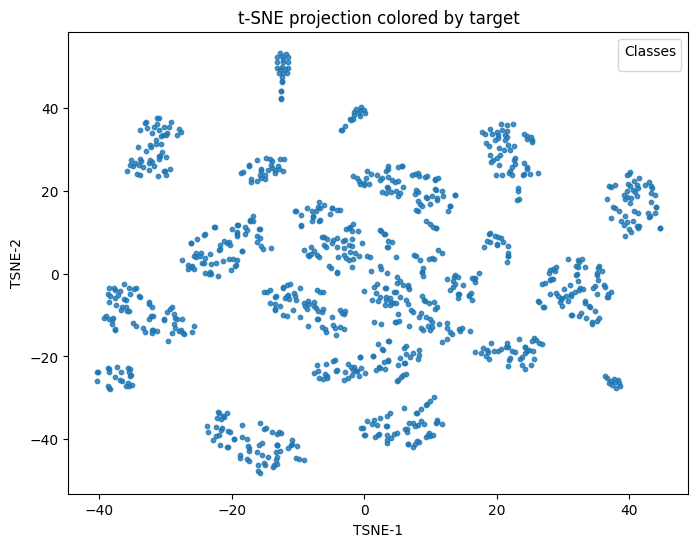

In [70]:
tsne = TSNE(
    n_components=2,
    perplexity=30,
    learning_rate=200,
    n_iter=1000,
    random_state=42
)

X_tsne = tsne.fit_transform(X_test_scaled)

plt.figure(figsize=(8,6))

scatter = plt.scatter(
    X_tsne[:,0],
    X_tsne[:,1],
    cmap='tab10',
    s=10,
    alpha=0.8
)

plt.title('t-SNE projection colored by target')
plt.xlabel('TSNE-1')
plt.ylabel('TSNE-2')
plt.legend(*scatter.legend_elements(), title="Classes")
plt.show()

In [104]:
submission_df = pd.DataFrame({
    'worker_id': worker_id,
    'financial_stress_level': y_test_pred
}).reset_index(drop=True)

target_map_inv = {v: k for k, v in target_map.items()}
submission_df['financial_stress_level'] = submission_df['financial_stress_level'].map(target_map_inv)

In [117]:
submission_df.to_csv('submission.csv', index=False)